In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import warnings
import itertools
from sklearn.metrics import mean_absolute_error as mae
import random
from random import randint
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
import pickle
import datetime
from ML-OPT-IA-Algorithms.ACO import ACO
from ML-OPT-IA-Algorithms.AGMLP_Residual import AGMLP_Residual
from ML-OPT-IA-Algorithms.AGMLP_VR_Residual import AGMLP_VR_Residual
from ML-OPT-IA-Algorithms.AGEnsemble_Residual import AGEnsemble_Residual
from ML-OPT-IA-Algorithms.TimeSeriesUtils import *
import pyswarms as ps

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# Data Correction Functions

In [ ]:
def correct_apac(df_in, hour_range=(5,19)):
    
    df_apac = df_in.copy()
    df_apac = df_apac[df_apac.dia != "dia"]
    
    df_apac['Datetime']=pd.to_datetime(df_apac.dia.apply(str)+"/"+df_apac.mes.apply(str)+"/"+\
                                       df_apac.ano.apply(str), format="%d/%b/%Y")+\
                                       df_apac['hora(utc)'].apply(lambda x: datetime.timedelta(hours=int(x)))
    
    df_apac.drop_duplicates(subset="Datetime", inplace=True)
    
    inicio = datetime.datetime.strptime("01/"+str(df_apac.Datetime.iloc[0].month)+"/"+\
            str(df_apac.Datetime.iloc[0].year) + " "+ str(datetime.timedelta(hours=0)), "%d/%m/%Y %H:%M:%S")
    
    fim = df_apac.Datetime.iloc[-1]
    idx = pd.date_range(start=inicio,end=fim,freq='1H')
    
    #print(len(df_apac), len(df_apac.Datetime.unique()))
    
    df_apac = df_apac.set_index('Datetime').reindex(idx).reset_index().fillna(method='ffill')
    df_apac = df_apac[df_apac['hora(utc)'].isin(range(hour_range[0], hour_range[1]))]
    df_apac.drop(['ano','mes', 'dia', 'hora(utc)'],inplace=True,axis = 1)# drop duplicate infomation
        
    return df_apac

def correct_inmet(df_in, hour_range=(5,19)):
    
    df_inmet = df_in.copy()
    df_inmet.replace('////', np.nan, inplace=True)
    
    columns_to_numeric = list(set(df_inmet.columns) - set(["codigo_estacao","data","hora","planta"]))
        
    df_inmet[columns_to_numeric] = df_inmet[columns_to_numeric].apply(pd.to_numeric)
    df_inmet['Datetime']=pd.to_datetime(df_inmet.data, format="%d/%m/%Y")\
                    +df_inmet.hora.apply(lambda x: datetime.timedelta(hours=x))
    
    inicio = datetime.datetime.strptime("01/"+str(df_inmet.Datetime.iloc[0].month)+"/"+\
            str(df_inmet.Datetime.iloc[0].year) + " "+ str(datetime.timedelta(hours=0)), "%d/%m/%Y %H:%M:%S")
        
    fim = df_inmet.Datetime.iloc[-1]
    idx = pd.date_range(start=inicio,end=fim,freq='1H')

    df_inmet = df_inmet.set_index('Datetime').reindex(idx).reset_index().fillna(method='ffill')
    
    df_inmet = df_inmet[df_inmet['hora'].isin(range(hour_range[0], hour_range[1]))]
    df_inmet.drop(['data','hora'],inplace=True,axis = 1)# drop duplicate infomation
     
    return df_inmet

def correct_gen(df_in, hour_range=(5,19)):
    
    df_gen = df_in.copy()
    df_gen['HoraInt'] = df_gen.Hora.apply(lambda x: int(x.hour))
    df_gen = df_gen[df_gen['HoraInt'].isin(range(hour_range[0], hour_range[1]))]
    df_gen.drop(['HoraInt'], inplace=True, axis=1)
    
    return df_gen


# Load and Process Data

In [ ]:
inmet_csv = './historical_data_maceio.csv'
save_scaler = "maceio_MaxAbsScaler_gen.pckl"

df_inmet = pd.read_csv(inmet_csv, sep=',', encoding = "ISO-8859-1")

for c in df_inmet.columns:
    if (c not in ['data', 'hora']) and (df_inmet[c].dtype != "float64"):
        print(df_inmet[c].dtype)
        df_inmet[c] = df_inmet[c].apply(lambda x: float(str(x).replace(",","."))).fillna(method='ffill')
    
print(df_inmet.dtypes)

ultimos_dias = 360*24

posicao_final=len(df_inmet)
posicao_inicial=posicao_final - ultimos_dias

exog = df_inmet[['preciptacao_total_mm', 'temp_ar_bulbo_seco_c', 'umidade_relativa_prcnt',
                 'vento_velocidade_mps']].iloc[posicao_inicial:,:]

gen = df_inmet['radiacao_global_wpm2'].iloc[posicao_inicial:].values.reshape(-1,1)

MaxAbsScaler_exog = MaxAbsScaler().fit(exog)
MaxAbsScaler_gen = MaxAbsScaler().fit(gen)

exog = MaxAbsScaler_exog.transform(exog)
gen = MaxAbsScaler_gen.transform(gen)[:,0]
pickle.dump(MaxAbsScaler_gen, open('MaxAbsScaler_gen.pckl', 'wb'))

# SARIMAX 

## Grid Search Parametrization

In [ ]:
y_sarimax = sarimax_serial_search(gen, exog, search=False, param_default=(1, 1, 1), param_seasonal_default=(1, 1, 1, 24))

## PSO-ACO Parametrization

In [ ]:
p = d = q = [0, 1, 2]#range(0, 2)
sp = sd = sq = [0]#range(0, 2)
s = [24] #12,24,48 como são dados horarios...
X = [p, d, q, sp, sd, sq, s]

In [ ]:
# Set-up hyperparameters
options_PSO = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
options_ACO = {'antNumber':2, 'antTours':1, 'alpha':2, 'beta':2, 'rho':0.5, 'Q':2,'searchSpace':X,
               'endo':gen,'exog':exog, 'verbose':True}

sarimax_Exog_PSO_Wrapper_search(2, 4, exog, options_PSO, options_ACO)

## PSO Parametrization

In [ ]:
sarimax_Exog_PSO_search(2, 4, searchSpace, exog_variables_matrix, options_PSO)

## DUMP Sarimax

In [ ]:
dict_gen_ysarimax = {'generation':gen, 'y_sarimax':y_sarimax, 'data_inicial':df_inmet.data.iloc[posicao_inicial]}
pickle.dump(dict_gen_ysarimax, open('dict_gen_ysarimax.pckl', 'wb'))

## LOAD Sarimax

In [ ]:
dict_gen_ysarimax = pickle.load(open('dict_gen_ysarimax.pckl', 'rb'))

gen = dict_gen_ysarimax['generation']
y_sarimax = dict_gen_ysarimax['y_sarimax']
data_inicial = dict_gen_ysarimax['data_inicial']

## Plot Best

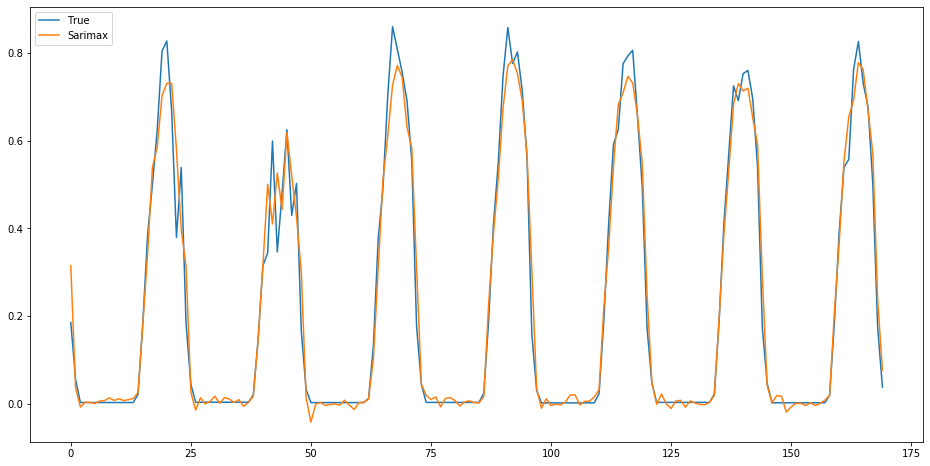

In [8]:
plt.figure(figsize=(16,8))
plt.plot(gen[-170:], label="True")
plt.plot(y_sarimax[-170:], label="Sarimax")
plt.legend()

# Algoritmo AGMLPResidual

In [10]:
ag_mlp_residual = AGMLP_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 10, prob_mut=0.5, tr_ts_percents=[80,20]).search_best_model()
best_mlp_residual = ag_mlp_residual._best_of_all
pickle.dump(best_mlp_residual, open('best_model_AGMLP_RESIDUAL.pckl', 'wb'))

start_set_fit: 0


  0%|          | 0/3 [00:00<?, ?it/s]

generation: 0
start_set_fit: 0


 33%|███▎      | 1/3 [01:39<03:19, 99.81s/it]

generation: 1
start_set_fit: 1


 67%|██████▋   | 2/3 [04:05<01:53, 113.69s/it]

generation: 2
start_set_fit: 3


100%|██████████| 3/3 [05:24<00:00, 108.15s/it]


## Análise Resultados

[12, 16, 16, 12, MLPRegressor(activation='identity', hidden_layer_sizes=(21, 32, 3),
             max_iter=500, solver='lbfgs'), MLPRegressor(hidden_layer_sizes=(40, 18, 4), learning_rate='invscaling',
             max_iter=500, solver='lbfgs'), 0.02545756937510593]
Teste para saber se pegou o melhor mesmo! 0.02545756937510593 == 0.02545756937510593 ?
True
Resultado Dados Teste!
SARIMAX
MAE:  0.04144526397808744
MSE:  0.004681787871899246
MAPE:  2.398928751219675
HIBRIDO
MAE:  0.02545756937510593
MSE:  0.0017107879715476198
MAPE:  1.6228248936019043
GANHO MAE:
0.38575444015592175
GANHO MSE:
0.6345866112781378
GANHO MAPE:
0.3235210121280927


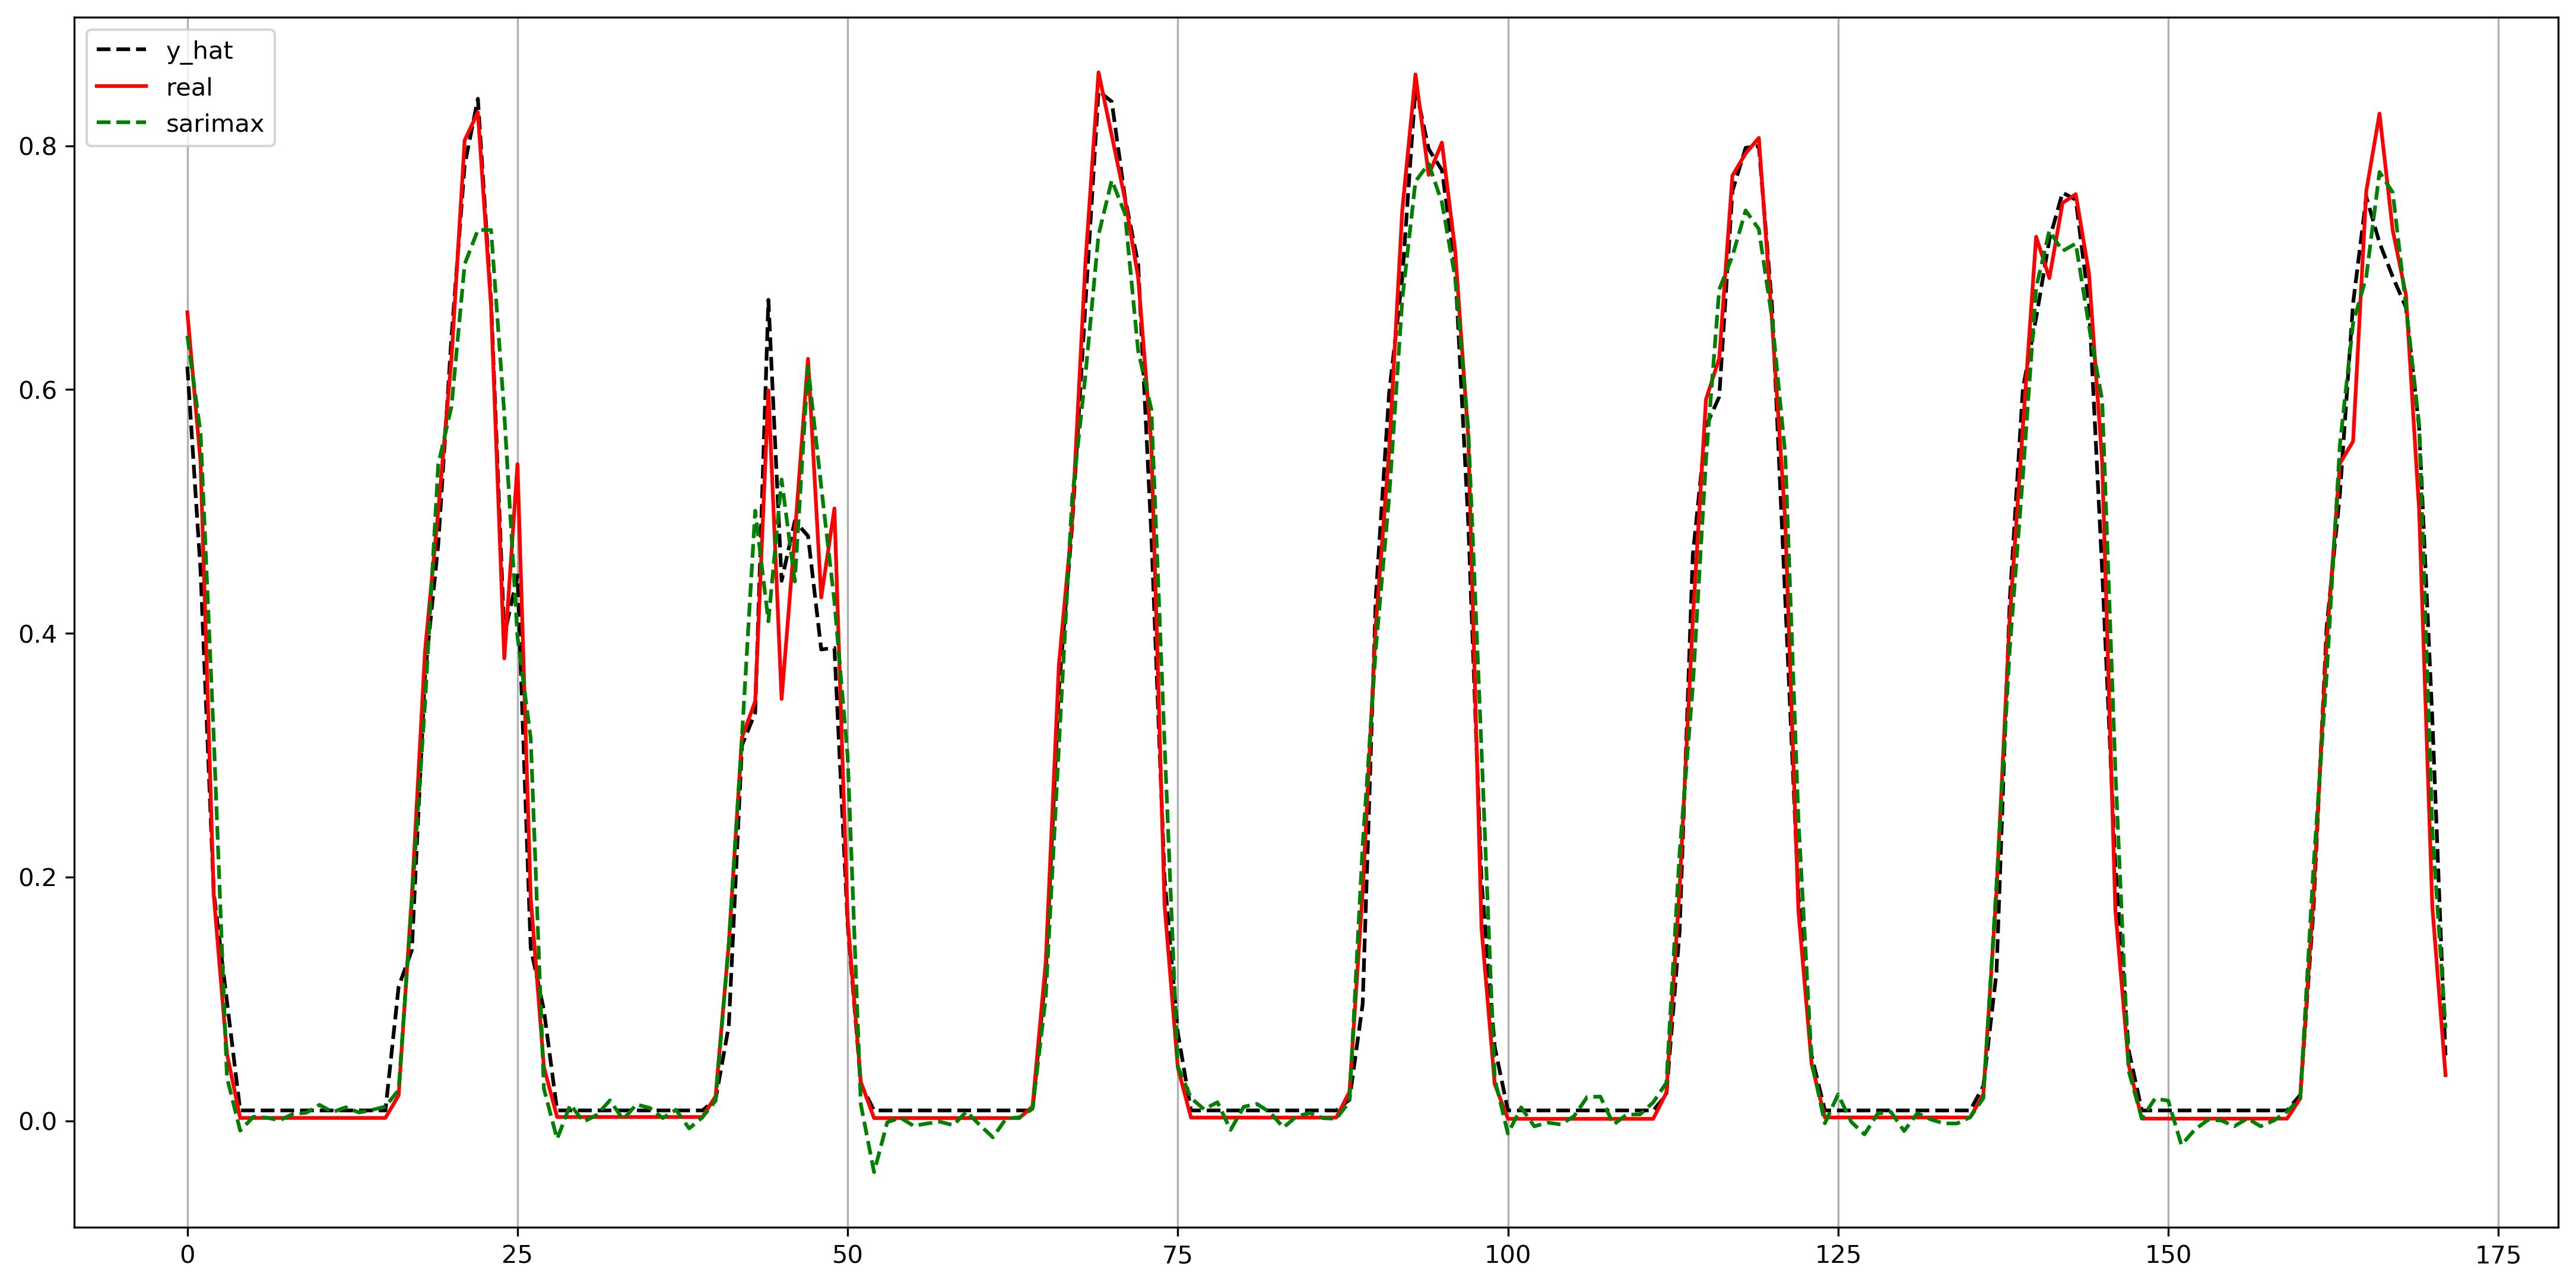

In [17]:
dict_series = pickle.load(open('dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('MaxAbsScaler_gen.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

best = pickle.load(open('best_model_AGMLP_RESIDUAL.pckl', 'rb'))

erro = gen - y_sarimax

threshold = int(len(y_sarimax)*0.8)

data_train = gen[0:threshold]
data_test = gen[threshold:]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], [80, 20])
erro_estimado = np.concatenate((best[4].predict(erro_train_entrada), best[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], [80, 20])
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], [80, 20])

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[5].predict(X_in_train), best[5].predict(X_in_test)])
y_estimado_so_test = best[5].predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

len_dsh = int(len_dt/10)

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dsh:], 'k--', label='y_hat')
plt.plot(gen[-len_dsh:], 'r', label='real')
plt.plot(y_sarimax[-len_dsh:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

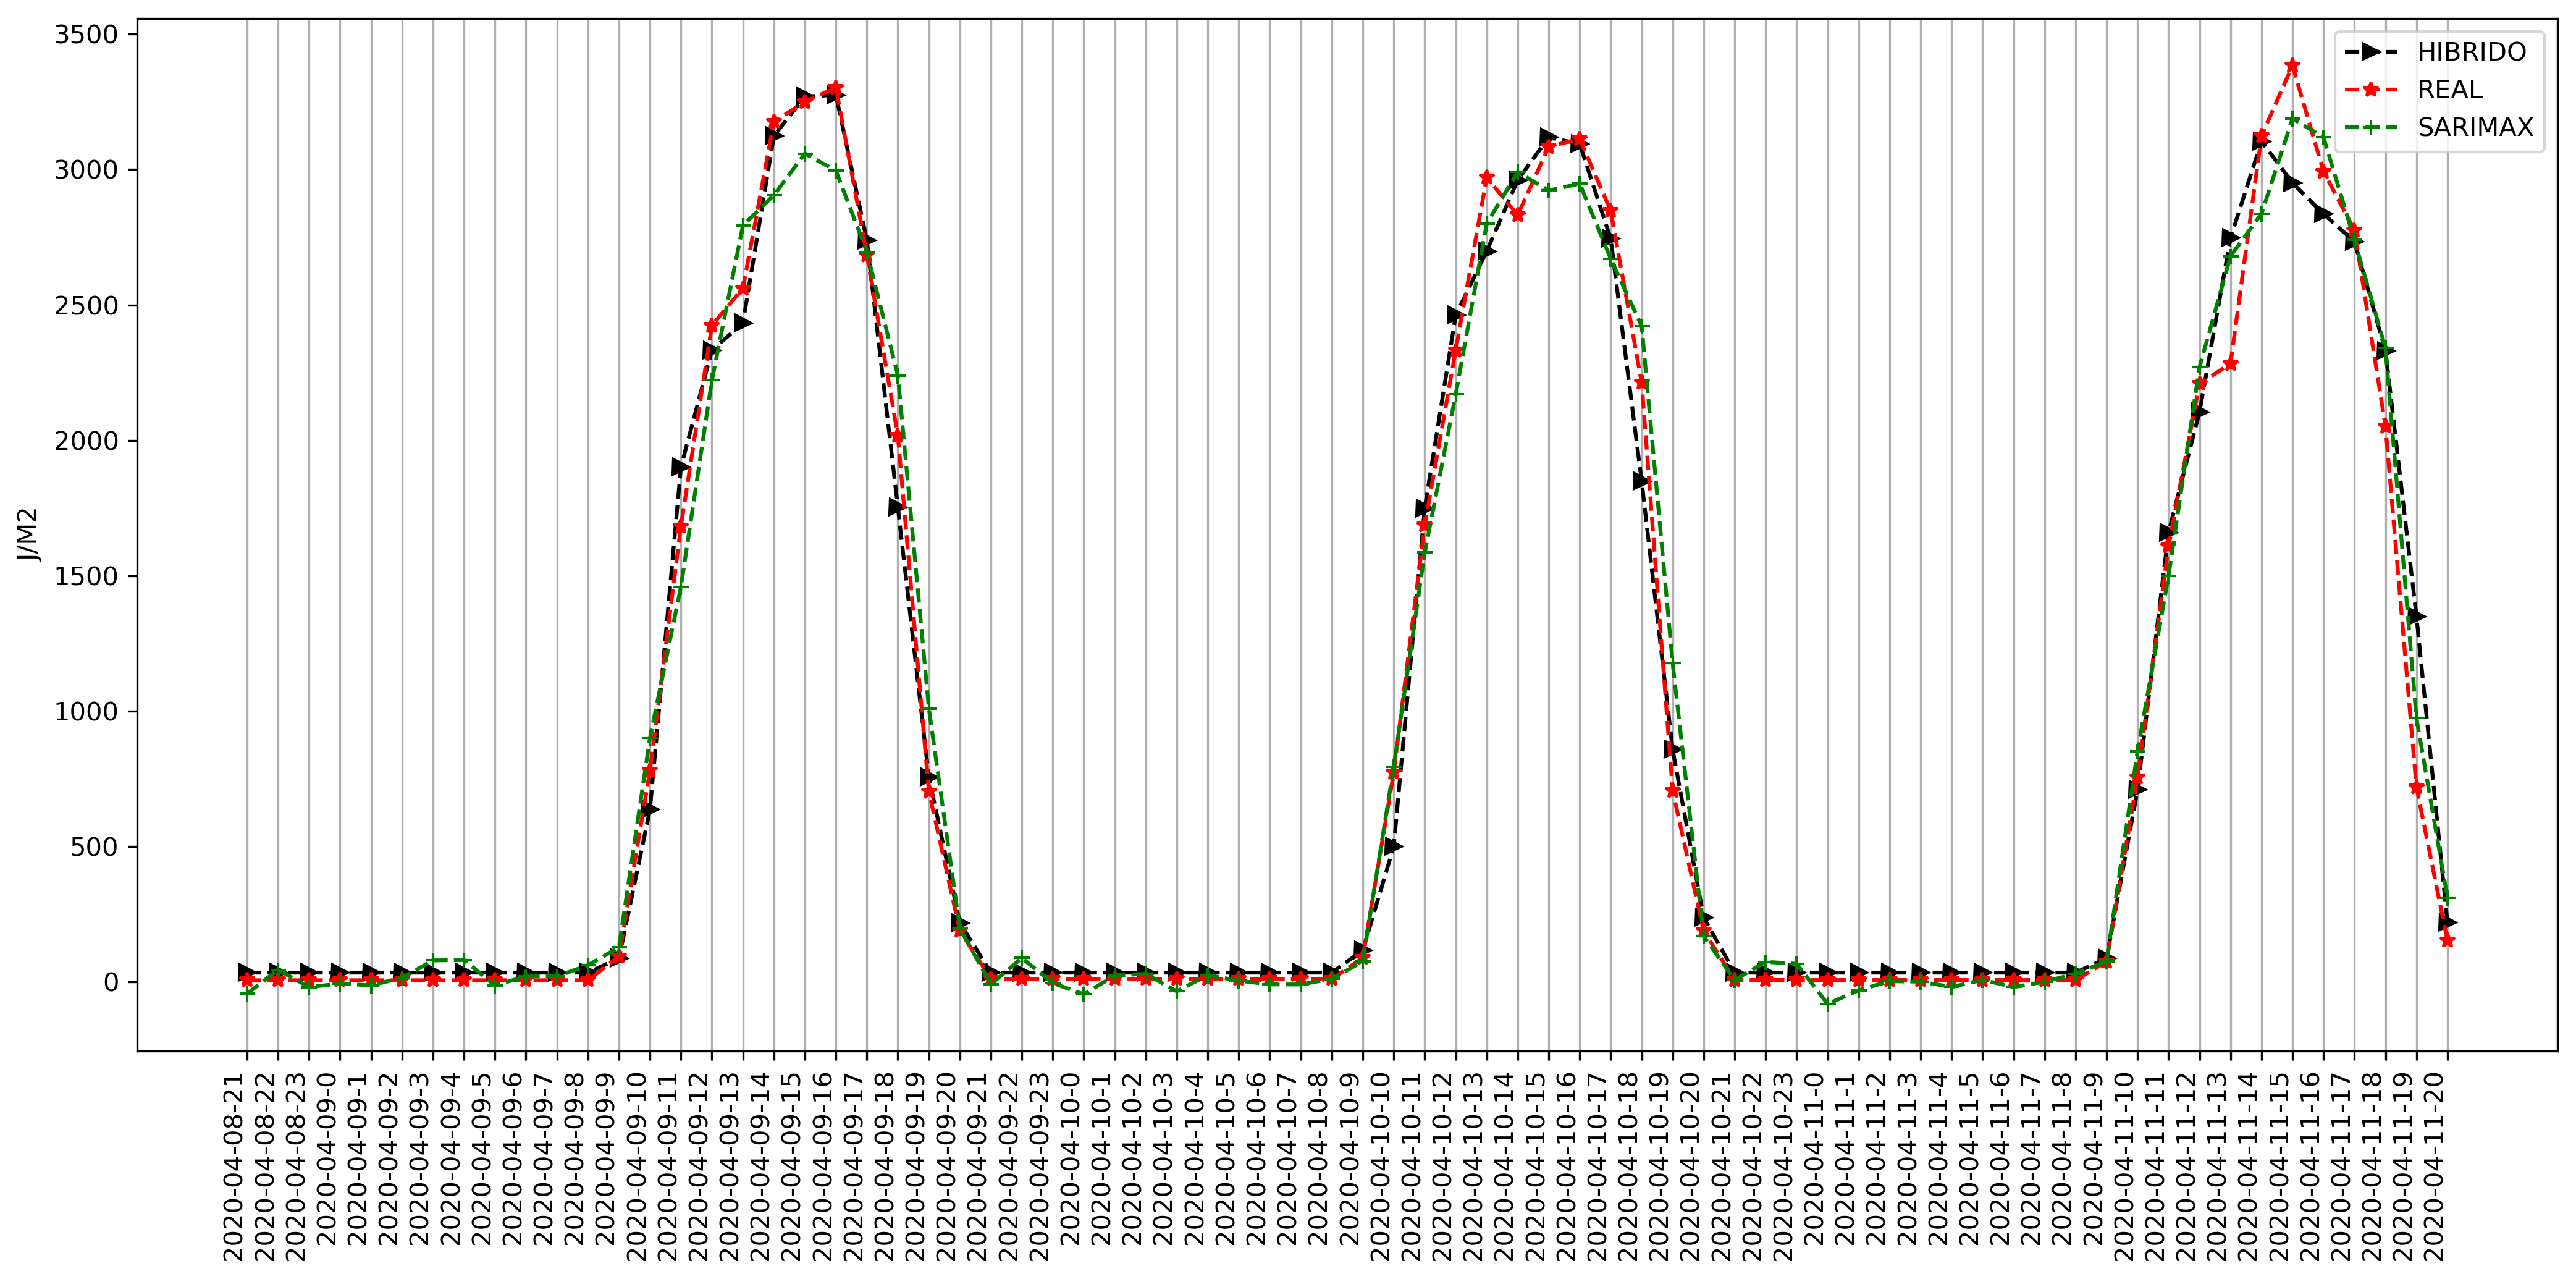

In [18]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

last_hours = 3*24

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-last_hours:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado[-last_hours:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-last_hours:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-last_hours:].reshape(-1, 1)), 'g--+', label='SARIMAX')
plt.xticks(ticks_X, rotation=90, ha='right', fontsize=10)
ax.grid(axis='x')
    
ax.legend(fontsize=10)
ax.set_ylabel('J/M2', fontsize=10)
plt.tight_layout()
plt.savefig('maceio_agmlpresidual_epoch3_pop10.png', dpi=300)

# Algoritmo AGMLP_VR_Residual

In [5]:
ag_mlp_vr_residual = AGMLP_VR_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 10,
                                       prob_mut=0.5, tr_ts_percents=[80,20]).search_best_model()

best_mlp_vr_residual = ag_mlp_vr_residual._best_of_all

pickle.dump(best_mlp_vr_residual, open('best_model_AGMLP_VR_RESIDUAL.pckl', 'wb'))

start_set_fit: 0
len poulation 4


  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4


 50%|█████     | 1/2 [00:02<00:02,  2.51s/it]

len poulation 4


100%|██████████| 2/2 [00:04<00:00,  2.48s/it]


len poulation 4


  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4


 50%|█████     | 1/2 [00:07<00:07,  7.40s/it]

len poulation 4


100%|██████████| 2/2 [00:12<00:00,  6.43s/it]


len poulation 4


  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4


 50%|█████     | 1/2 [00:01<00:01,  1.32s/it]

len poulation 4


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


len poulation 4


  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4


 50%|█████     | 1/2 [00:09<00:09,  9.01s/it]

len poulation 4


100%|██████████| 2/2 [00:11<00:00,  5.71s/it]


len poulation 4


  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4


 50%|█████     | 1/2 [00:02<00:02,  2.86s/it]

len poulation 4


100%|██████████| 2/2 [00:05<00:00,  2.67s/it]


len poulation 4


  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4


 50%|█████     | 1/2 [00:07<00:07,  7.95s/it]

len poulation 4


100%|██████████| 2/2 [00:13<00:00,  6.63s/it]


len poulation 4


  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4


 50%|█████     | 1/2 [00:01<00:01,  1.66s/it]

len poulation 4


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


len poulation 4


  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4


 50%|█████     | 1/2 [00:08<00:08,  8.17s/it]

len poulation 4


  0%|          | 0/2 [00:00<?, ?it/s]

generation: 0
start_set_fit: 0
len poulation 4



  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4



 50%|█████     | 1/2 [00:01<00:01,  1.76s/it]

len poulation 4



100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


len poulation 4



  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4



 50%|█████     | 1/2 [00:53<00:53, 53.57s/it]

len poulation 4



100%|██████████| 2/2 [01:30<00:00, 45.24s/it]


len poulation 4



  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4



 50%|█████     | 1/2 [00:02<00:02,  2.90s/it]

len poulation 4



100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


len poulation 4



  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4



 50%|█████     | 1/2 [00:20<00:20, 20.72s/it]

len poulation 4



100%|██████████| 2/2 [00:39<00:00, 19.59s/it]


len poulation 4



  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4



 50%|█████     | 1/2 [00:02<00:02,  2.62s/it]

len poulation 4



100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


len poulation 4



  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4



 50%|█████     | 1/2 [00:19<00:19, 19.04s/it]

len poulation 4



100%|██████████| 2/2 [00:48<00:00, 24.47s/it]


len poulation 4



  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4



 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

len poulation 4



100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


len poulation 4



  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4



 50%|█████     | 1/2 [00:14<00:14, 14.58s/it]

len poulation 4



 50%|█████     | 1/2 [04:53<04:53, 293.40s/it]

generation: 1
start_set_fit: 1
len poulation 4



  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4



 50%|█████     | 1/2 [00:04<00:04,  4.40s/it]

len poulation 4



100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


len poulation 4



  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4



 50%|█████     | 1/2 [00:10<00:10, 10.77s/it]

len poulation 4



100%|██████████| 2/2 [00:19<00:00,  9.88s/it]


len poulation 4



  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4



 50%|█████     | 1/2 [00:01<00:01,  1.36s/it]

len poulation 4



100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


len poulation 4



  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4



 50%|█████     | 1/2 [00:02<00:02,  2.40s/it]

len poulation 4



100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


len poulation 4



  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4



 50%|█████     | 1/2 [00:02<00:02,  2.53s/it]

len poulation 4



100%|██████████| 2/2 [00:04<00:00,  2.49s/it]


len poulation 4



  0%|          | 0/2 [00:00<?, ?it/s]

len poulation 4



 50%|█████     | 1/2 [00:17<00:17, 17.08s/it]

len poulation 4



100%|██████████| 2/2 [06:31<00:00, 195.76s/it]


## Análise Resultados

[12, 18, 16, 20, <hibridmodels.AgMlp.AgMlp object at 0x0000024479D94CF8>, <hibridmodels.AgMlp.AgMlp object at 0x0000024479D99978>, 0.026173392336113908]
Teste para saber se pegou o melhor mesmo! 0.026173392336113908 == 0.026173392336113908 ?
True
Resultado Dados Teste!
SARIMAX
MAE:  0.04144526397808744
MSE:  0.004681787871899246
MAPE:  2.398928751219675
HIBRIDO
MAE:  0.026173392336113908
MSE:  0.0018224257874074818
MAPE:  1.373967748057328
GANHO MAE:
0.3684829139958654
GANHO MSE:
0.6107414865278413
GANHO MAPE:
0.4272577927298722


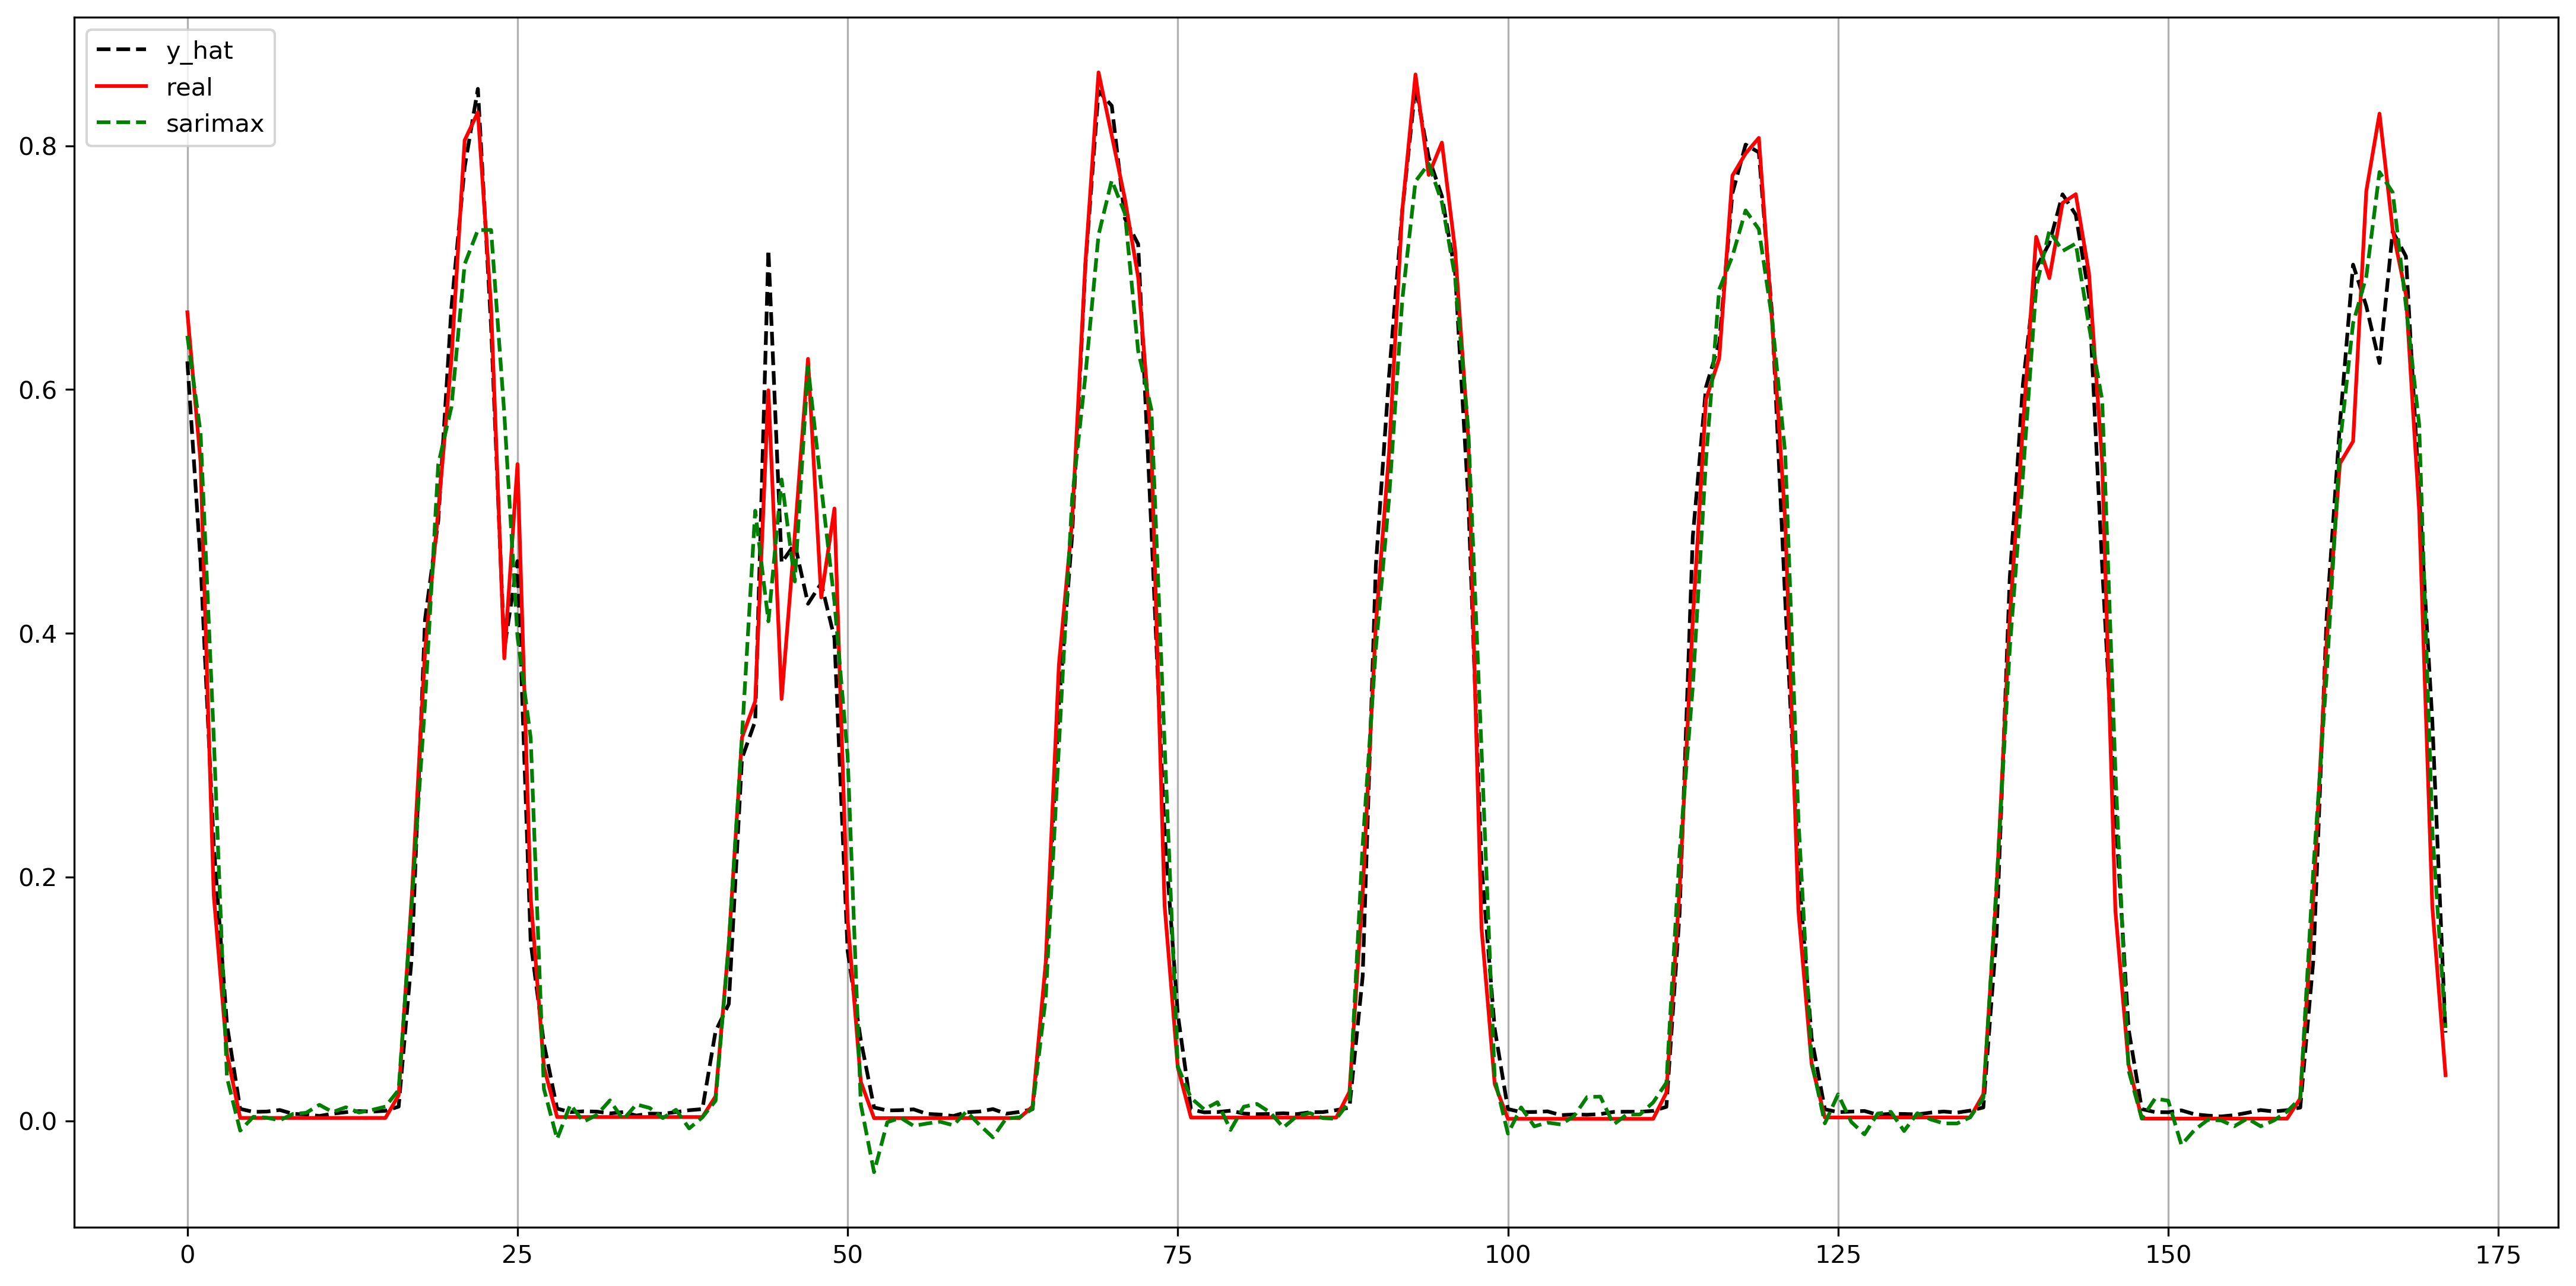

In [15]:
dict_series = pickle.load(open('dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('MaxAbsScaler_gen.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

best = pickle.load(open('best_model_AGMLP_VR_RESIDUAL.pckl', 'rb'))

erro = gen - y_sarimax

threshold = int(len(y_sarimax)*0.8)

data_train = gen[0:threshold]
data_test = gen[threshold:]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], [80, 20])
erro_estimado = np.concatenate((best[4].VR_predict(erro_train_entrada), best[4].VR_predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], [80, 20])
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], [80, 20])

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[5].VR_predict(X_in_train), best[5].VR_predict(X_in_test)])
y_estimado_so_test = best[5].VR_predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

len_dsh = int(len_dt/10)

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dsh:], 'k--', label='y_hat')
plt.plot(gen[-len_dsh:], 'r', label='real')
plt.plot(y_sarimax[-len_dsh:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

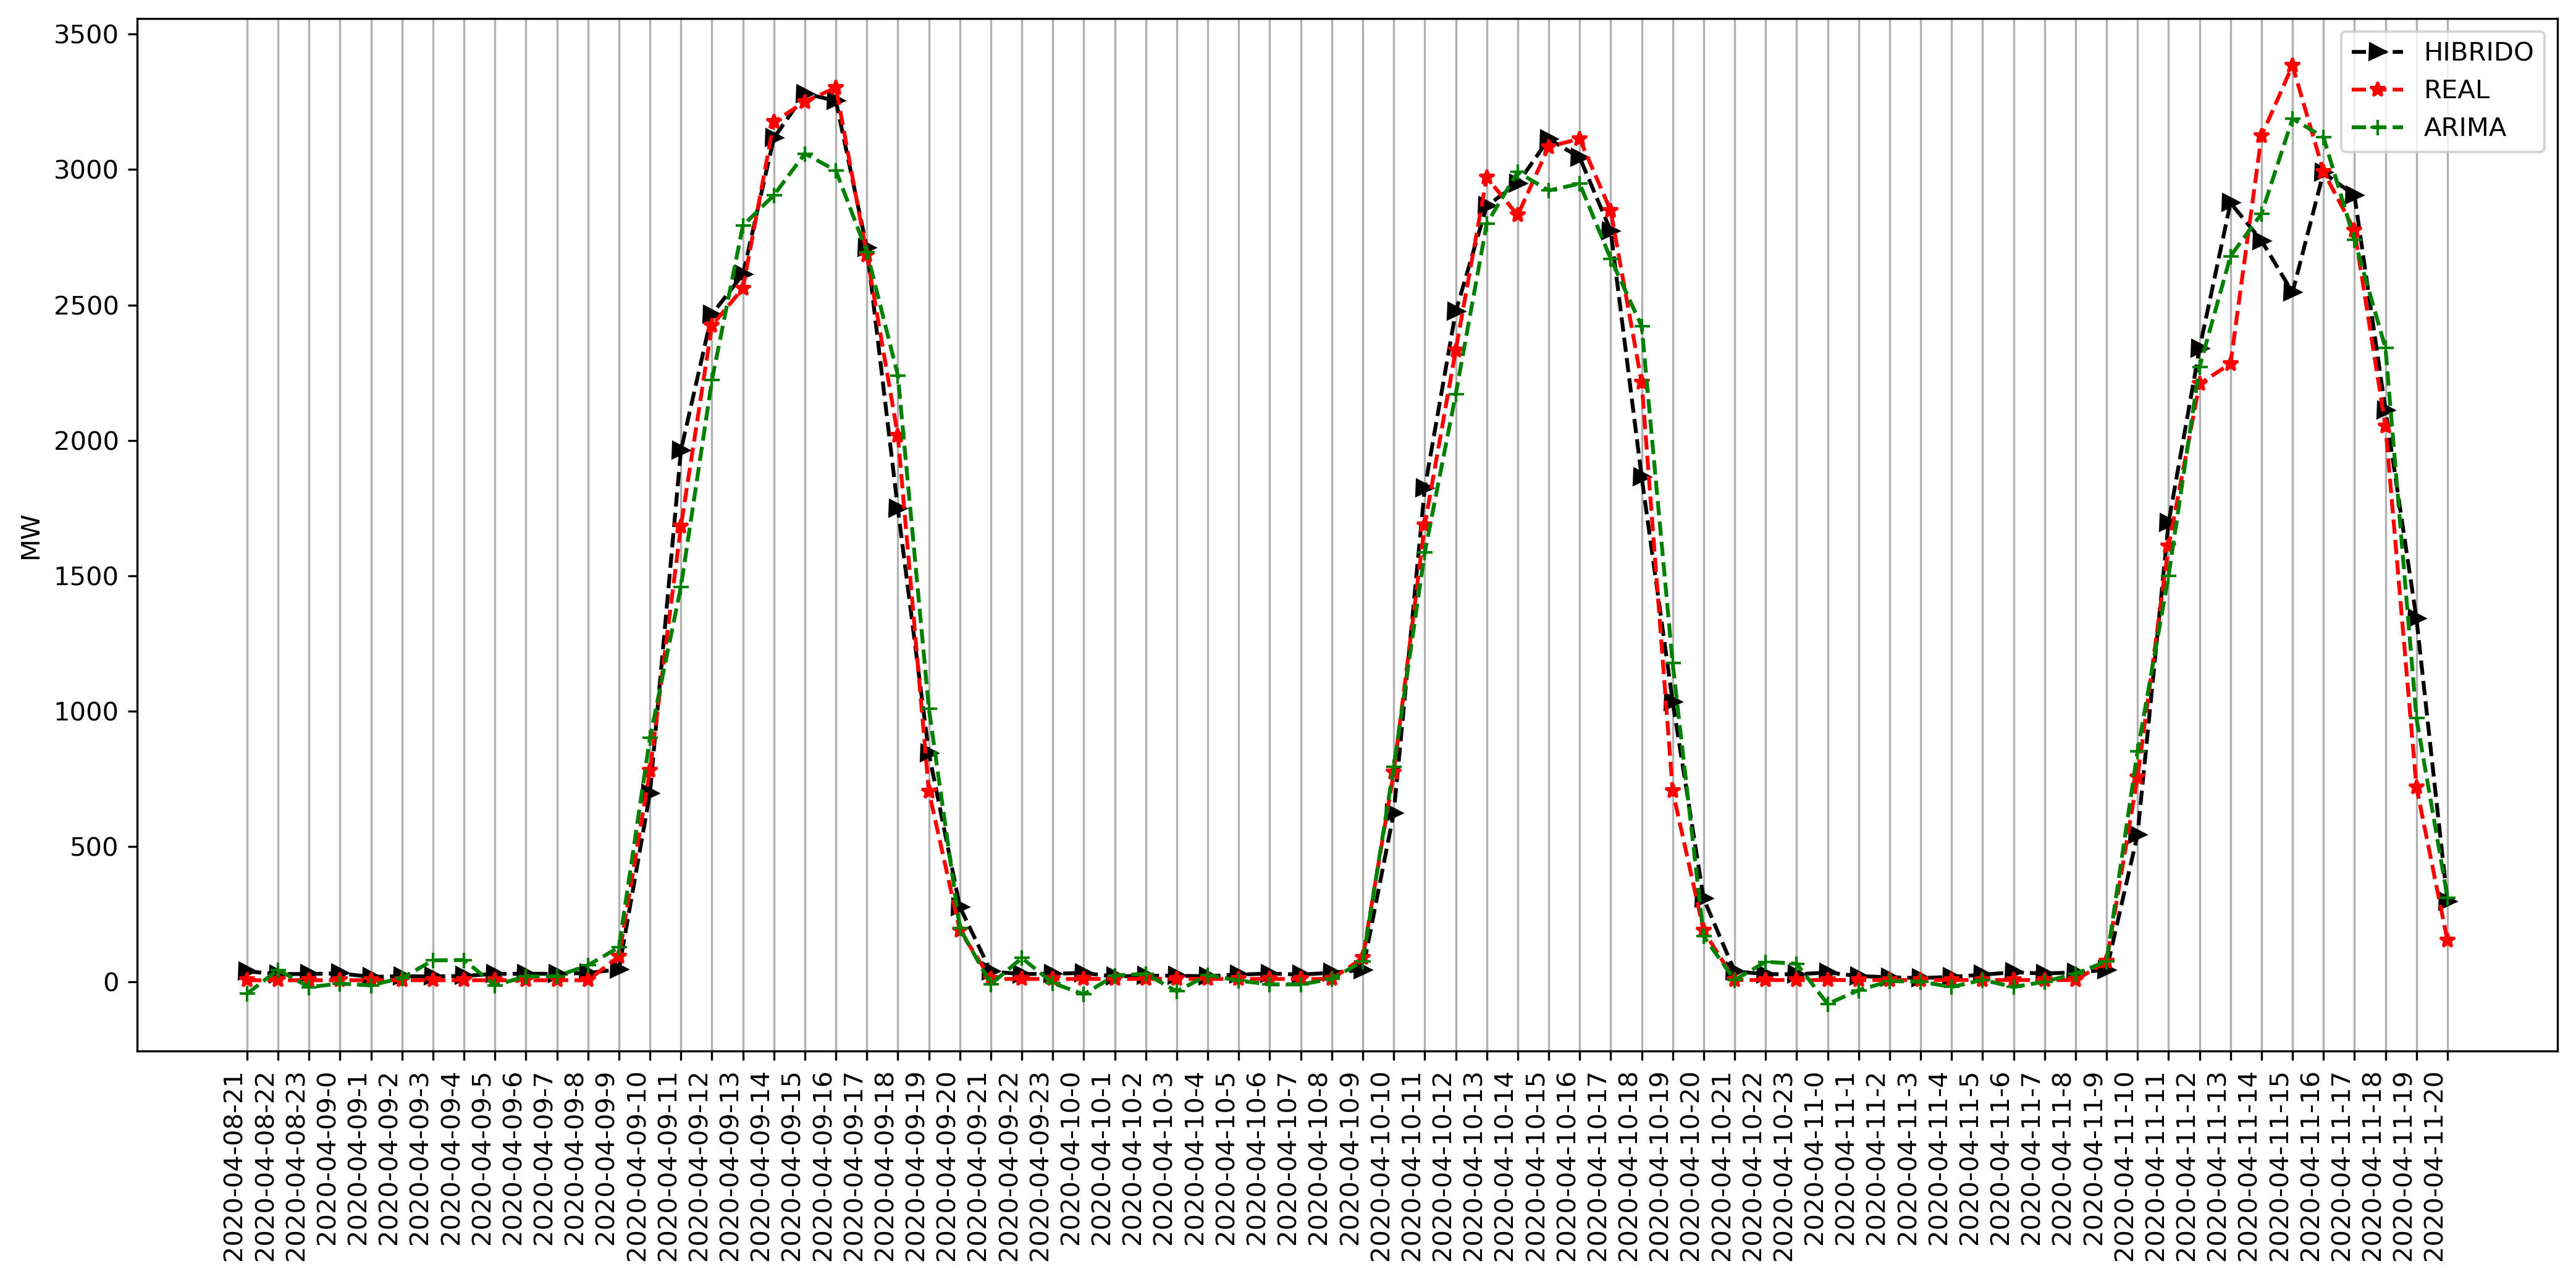

In [16]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

last_hours = 3*24

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-last_hours:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-last_hours:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-last_hours:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-last_hours:].reshape(-1, 1)), 'g--+', label='ARIMA')
plt.xticks(ticks_X, rotation=90, ha='right', fontsize=10)
ax.grid(axis='x')
    
ax.legend(fontsize=10)
ax.set_ylabel('MW', fontsize=10)
plt.tight_layout()
plt.savefig('maceio_agmlpvrresidual_epoch3_pop10.png', dpi=300)

# Algoritmo AGEmsemble_Residual


In [9]:
agensemble_residual = AGEnsemble_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 10,
                                       prob_mut=0.5, tr_ts_percents=[80,20]).search_best_model()

best_agensemble_residual = agensemble_residual._best_of_all

pickle.dump(best_agensemble_residual, open('best_model_AGEmsemble_RESIDUAL.pckl', 'wb'))

start_set_fit: 0


  0%|          | 0/3 [00:00<?, ?it/s]

generation: 0
start_set_fit: 0



100%|██████████| 3/3 [01:00<00:00, 20.07s/it]

100%|██████████| 3/3 [12:45<00:00, 255.07s/it]

100%|██████████| 3/3 [00:39<00:00, 13.16s/it]

100%|██████████| 3/3 [01:00<00:00, 20.03s/it]

100%|██████████| 3/3 [00:27<00:00,  9.30s/it]

100%|██████████| 3/3 [01:05<00:00, 21.99s/it]

100%|██████████| 3/3 [00:18<00:00,  6.11s/it]

100%|██████████| 3/3 [01:03<00:00, 21.30s/it]

100%|██████████| 3/3 [00:17<00:00,  5.92s/it]

100%|██████████| 3/3 [01:33<00:00, 31.17s/it]

100%|██████████| 3/3 [03:18<00:00, 66.25s/it]

100%|██████████| 3/3 [01:42<00:00, 34.07s/it]

100%|██████████| 3/3 [00:52<00:00, 17.57s/it]

100%|██████████| 3/3 [01:41<00:00, 33.77s/it]

100%|██████████| 3/3 [00:21<00:00,  7.12s/it]

100%|██████████| 3/3 [01:46<00:00, 35.42s/it]

100%|██████████| 3/3 [01:12<00:00, 24.16s/it]

100%|██████████| 3/3 [03:03<00:00, 61.05s/it]

100%|██████████| 3/3 [00:29<00:00,  9.95s/it]

 33%|███▎      | 1/3 [48:35<1:37:10, 2915.27s/it]

generation: 1
start_set_fit: 1



100%|██████████| 3/3 [00:57<00:00, 19.02s/it]

100%|██████████| 3/3 [02:02<00:00, 40.95s/it]

100%|██████████| 3/3 [01:05<00:00, 21.93s/it]

100%|██████████| 3/3 [02:30<00:00, 50.16s/it]

100%|██████████| 3/3 [01:25<00:00, 28.61s/it]

100%|██████████| 3/3 [02:46<00:00, 55.34s/it]

100%|██████████| 3/3 [00:16<00:00,  5.61s/it]

100%|██████████| 3/3 [01:53<00:00, 37.89s/it]

100%|██████████| 3/3 [01:08<00:00, 22.81s/it]

100%|██████████| 3/3 [02:56<00:00, 58.95s/it]

100%|██████████| 3/3 [00:14<00:00,  4.87s/it]

100%|██████████| 3/3 [01:47<00:00, 35.87s/it]

100%|██████████| 3/3 [00:46<00:00, 15.53s/it]

100%|██████████| 3/3 [01:36<00:00, 32.09s/it]

100%|██████████| 3/3 [00:28<00:00,  9.58s/it]

100%|██████████| 3/3 [16:59<00:00, 339.99s/it]

100%|██████████| 3/3 [00:35<00:00, 11.96s/it]

 67%|██████▋   | 2/3 [1:53:13<53:24, 3204.13s/it]

generation: 2
start_set_fit: 3



100%|██████████| 3/3 [07:41<00:00, 153.96s/it]

100%|██████████| 3/3 [06:09<00:00, 123.23s/it]

100%|██████████| 3/3 [00:57<00:00, 19.32s/it]

100%|██████████| 3/3 [26:47<00:00, 535.72s/it]

100%|██████████| 3/3 [00:41<00:00, 13.75s/it]

100%|██████████| 3/3 [02:51<00:00, 57.14s/it]

100%|██████████| 3/3 [03:25<00:00, 68.52s/it]

100%|██████████| 3/3 [01:54<00:00, 38.19s/it]

100%|██████████| 3/3 [00:35<00:00, 11.83s/it]

100%|██████████| 3/3 [01:56<00:00, 38.85s/it]

100%|██████████| 3/3 [01:54<00:00, 38.25s/it]

100%|██████████| 3/3 [02:31<00:00, 50.38s/it]

100%|██████████| 3/3 [00:54<00:00, 18.22s/it]

100%|██████████| 3/3 [3:14:23<00:00, 3887.95s/it]


## Análise Resultados

[15, 10, 20, 1, VotingRegressor(estimators=[('SVR',
                             SVR(C=100, epsilon=0.1742386833465867,
                                 gamma='auto')),
                            ('BAG',
                             BaggingRegressor(max_samples=3, n_estimators=2)),
                            ('SGD', SGDRegressor()),
                            ('RFR',
                             RandomForestRegressor(max_depth=19,
                                                   min_samples_leaf=6,
                                                   min_weight_fraction_leaf=0.1315589727589142,
                                                   n_estimators=1)),
                            ('ADA', AdaBoostRegressor(n_estimators=38)),
                            ('LR', LinearRegression())]), VotingRegressor(estimators=[('RFR',
                             RandomForestRegressor(max_depth=7,
                                                   min_samples_leaf=4,
                        

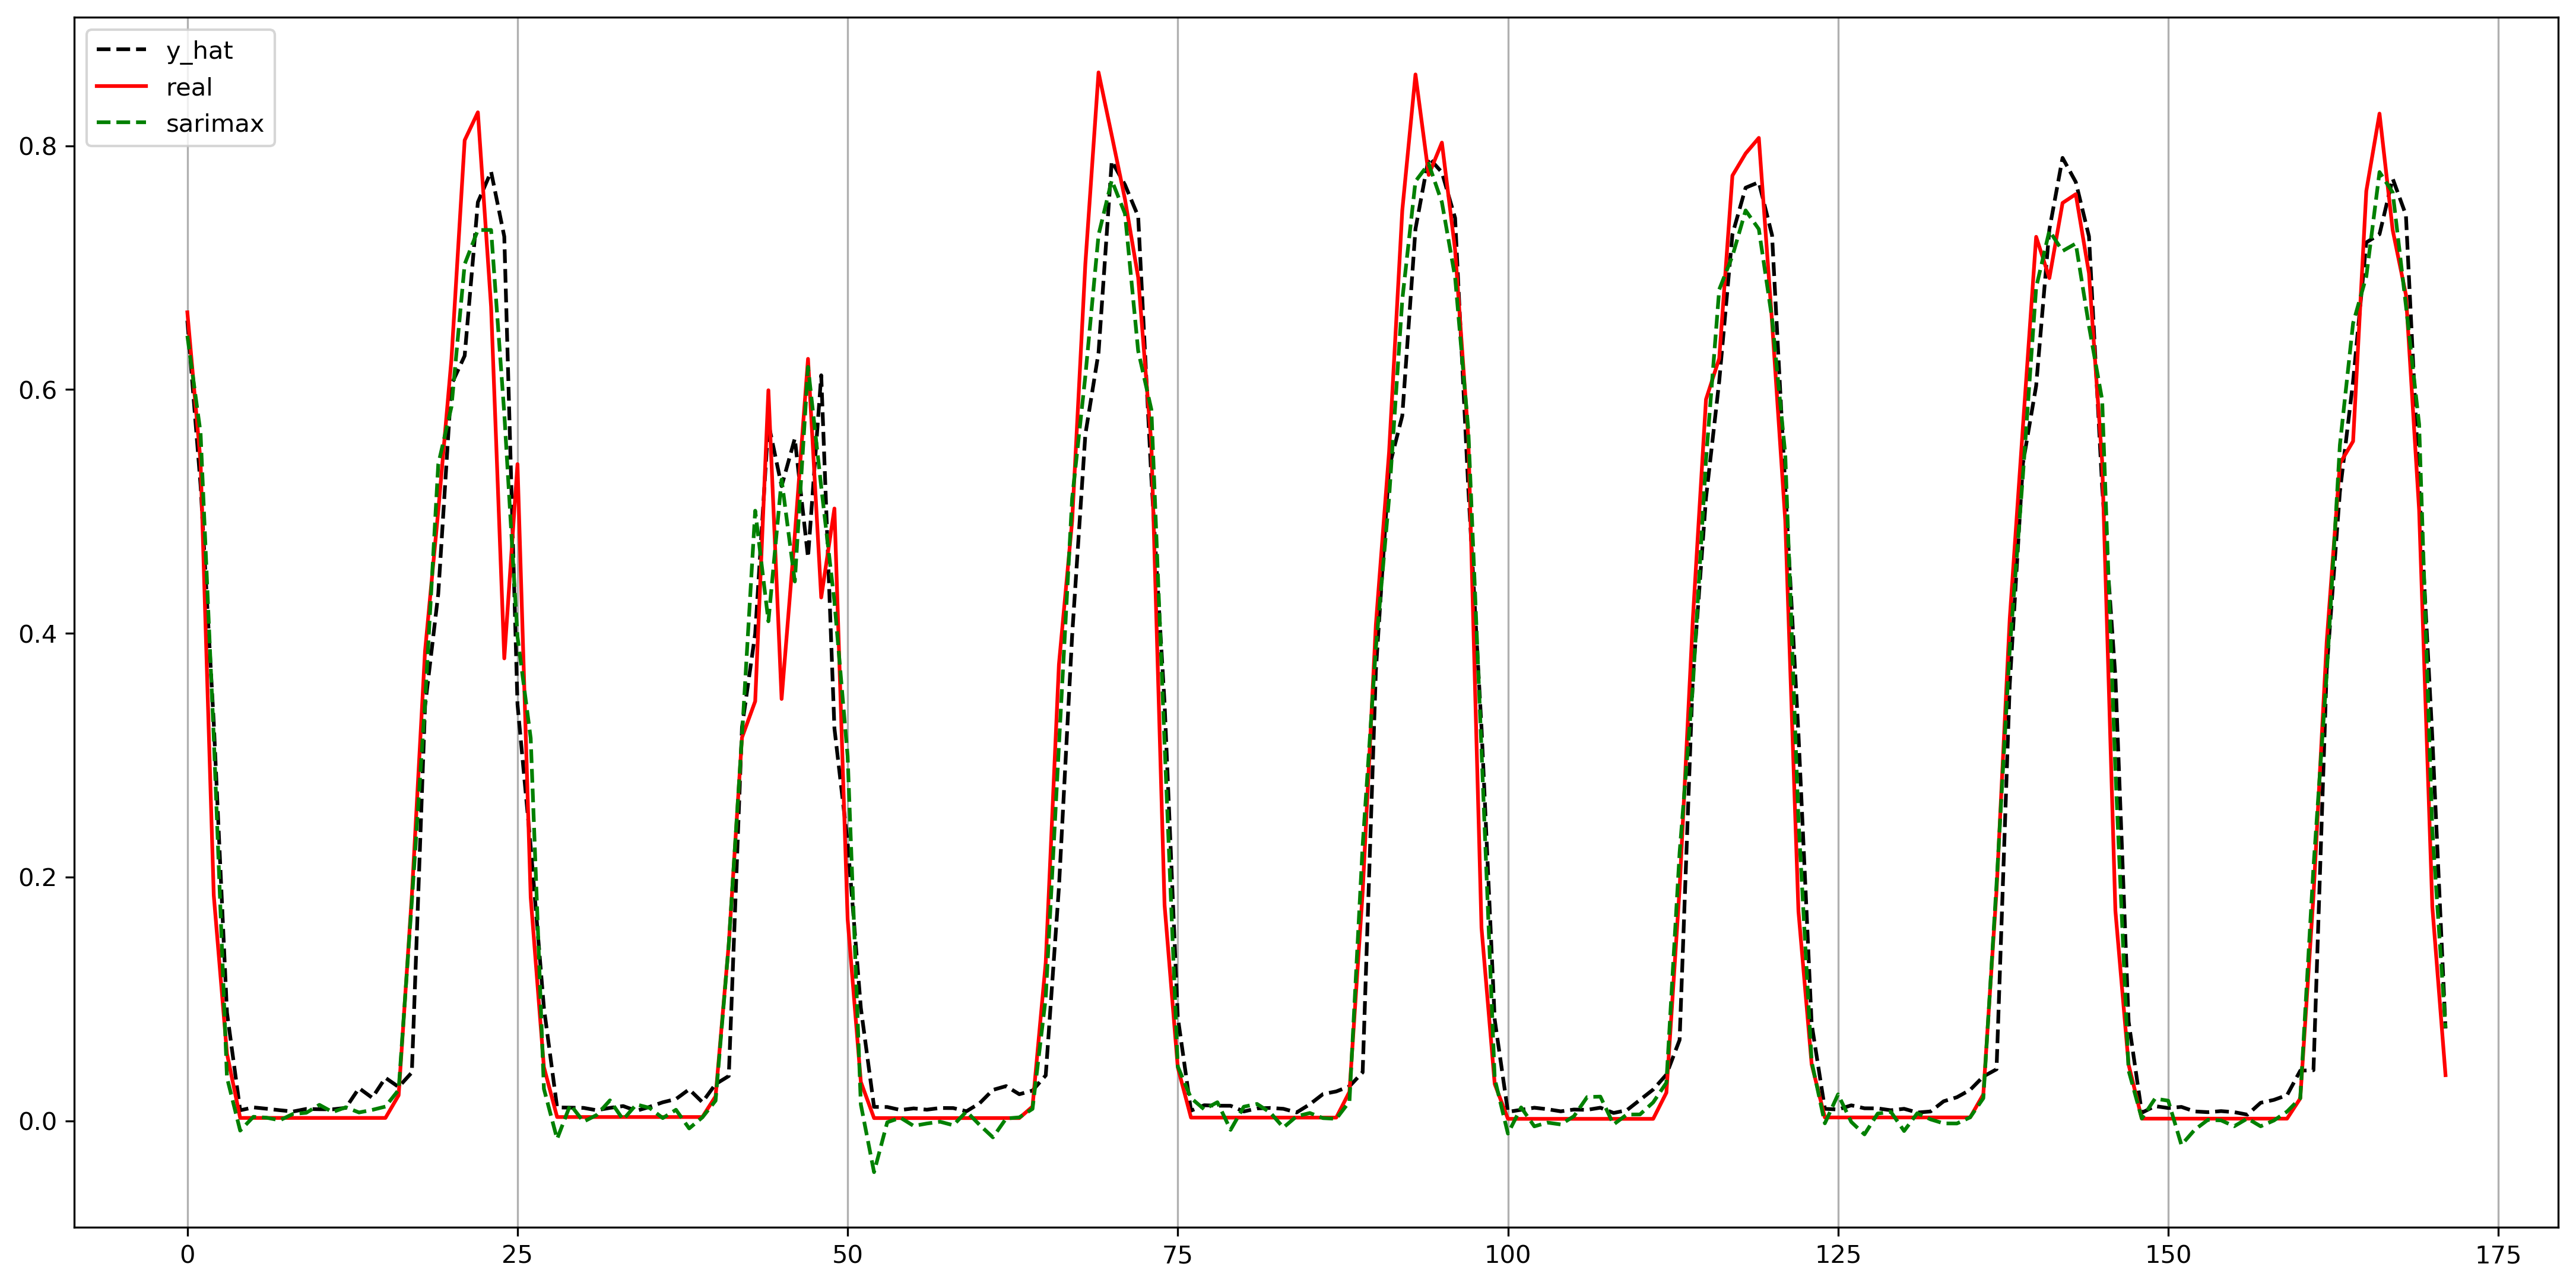

In [11]:
dict_series = pickle.load(open('dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('MaxAbsScaler_gen.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

best = pickle.load(open('best_model_AGEmsemble_RESIDUAL.pckl', 'rb'))

erro = gen - y_sarimax

threshold = int(len(y_sarimax)*0.8)

data_train = gen[0:threshold]
data_test = gen[threshold:]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], [80, 20])
erro_estimado = np.concatenate((best[4].predict(erro_train_entrada), best[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], [80, 20])
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], [80, 20])

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[5].predict(X_in_train), best[5].predict(X_in_test)])
y_estimado_so_test = best[5].predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

len_dsh = int(len_dt/10)

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dsh:], 'k--', label='y_hat')
plt.plot(gen[-len_dsh:], 'r', label='real')
plt.plot(y_sarimax[-len_dsh:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

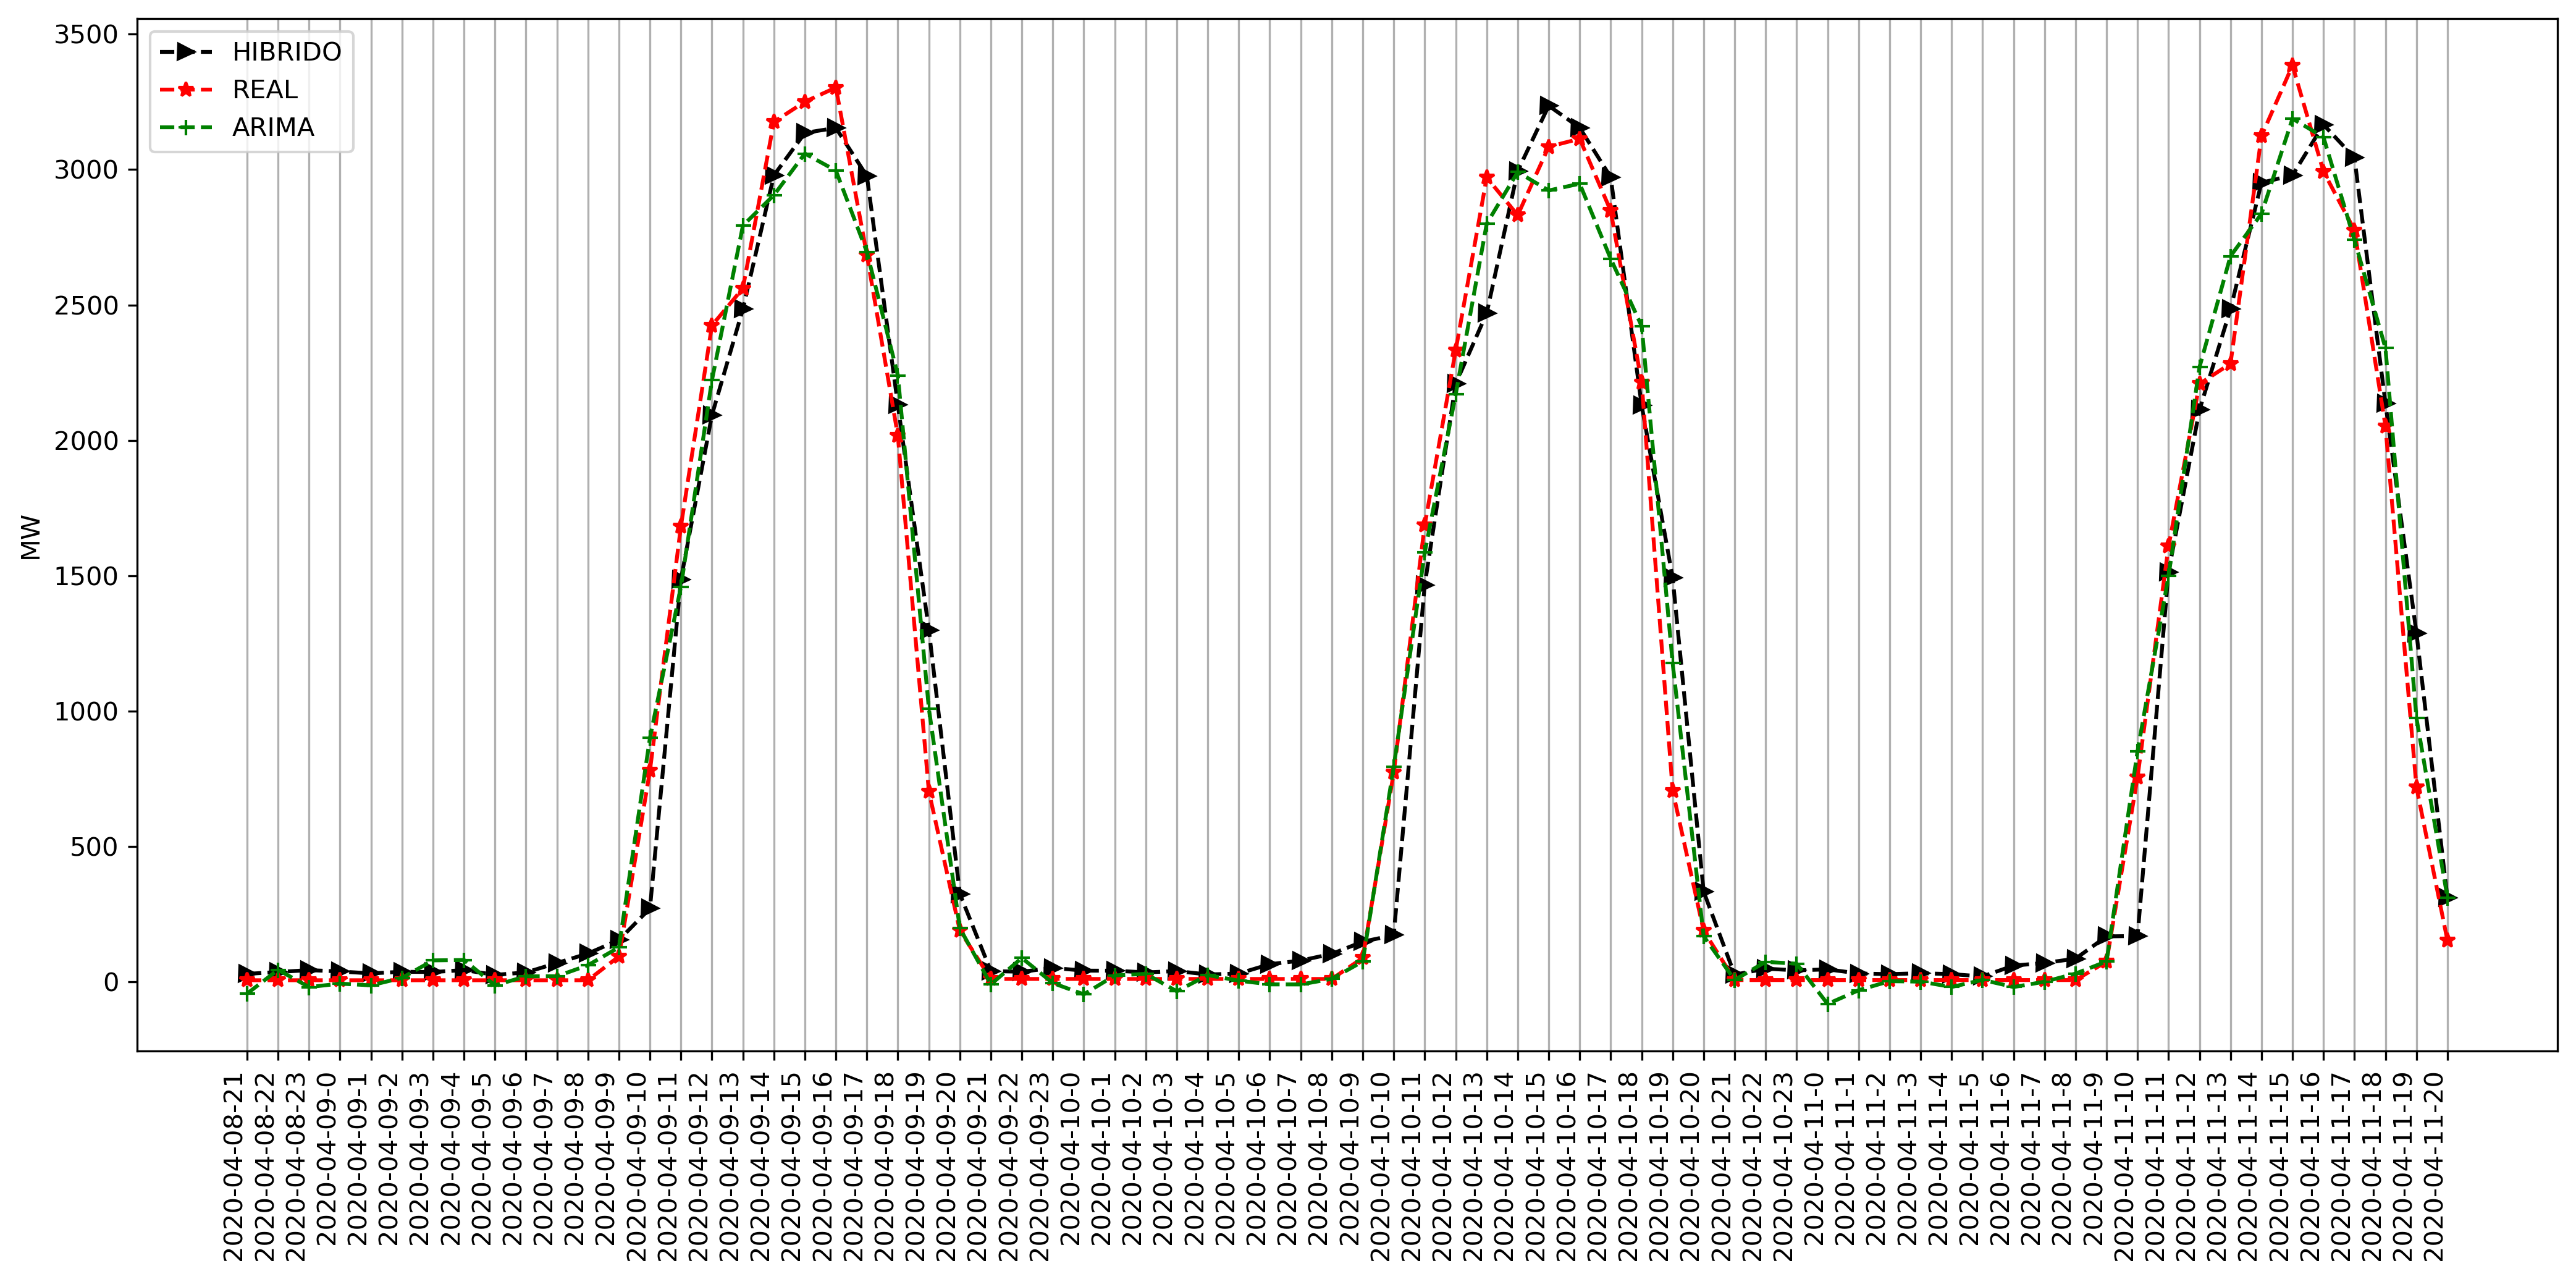

In [14]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

last_hours = 3*24

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-last_hours:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-last_hours:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-last_hours:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-last_hours:].reshape(-1, 1)), 'g--+', label='ARIMA')
plt.xticks(ticks_X, rotation=90, ha='right', fontsize=10)
ax.grid(axis='x')
    
ax.legend(fontsize=10)
ax.set_ylabel('MW', fontsize=10)
plt.tight_layout()
plt.savefig('maceio_agensembleresidual_epoch3_pop10.png', dpi=300)